### Neural Style Transfer
ref: https://www.kaggle.com/thekiingslayer/neural-style-transfer

This Deep Learning technique takes two images, namely, the content image(C) and a style image(S) and generate a new image(G) which combines the content of image C with style of image S.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import scipy
import imageio
from scipy import io
import tensorflow as tf
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

C:\Users\leo82\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Problem Formulation

We'll implement the algorithm in four main steps :
* Define content cost function : 
* Define style cost function
* Put it together to get final cost function.
* Optimization

If you want to see more details of definition of these cost function, you can read the original paper  [here](http://arxiv.org/abs/1508.06576).

## Content Cost

In [2]:
def compute_content_cost(a_C, a_G):
    """
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    Returns: 
    J_content
    """
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(tf.transpose(a_C,[0,3,1,2]),[m,n_C,-1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G,[0,3,1,2]),[m,n_C,-1])
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.squared_difference(a_C_unrolled,a_G_unrolled))/(4*n_H*n_W*n_C)
    return J_content

In [3]:
def style_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    Returns:
    GA -- style matrix of A, of shape (n_C, n_C)
    """
    M = tf.matmul(A,A,transpose_b=True)
    return M

In [4]:
def compute_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    Returns: 
    J_style
    """
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.reshape(tf.transpose(a_S,[0,3,1,2]),[m,n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G,[0,3,1,2]),[m,n_C,n_H*n_W])
    # Computing style_matrices for both images S and G
    M_S = style_matrix(a_S)
    M_G = style_matrix(a_G)
    # Computing the loss
    J_style = tf.reduce_sum(tf.squared_difference(M_S,M_G))/(4*(n_C**2)*((n_H*n_W)**2))
    return J_style

In [5]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    return J

#### Style weights

So far we've talked about capturing style from single layer only. It turns out we get more visual pleasing images if we capture style from multiple layers of network.

In [6]:
STYLE_LAYERS = [('conv1_1', 0.2),('conv2_1', 0.2),('conv3_1', 0.2),('conv4_1', 0.2),('conv5_4', 0.2)]

In [7]:
def compute_multiple_style_cost(model, STYLE_LAYERS):
    """
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                 - the names of the layers we would like to extract style from
                 - a coefficient for each of them
    Returns: 
    J_multiple_style
    """
    # initialize the overall style cost
    J_multiple_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)
        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        # Compute style_cost for the current layer
        J_style_layer = compute_style_cost(a_S, a_G)
        # Add coeff * J_style_layer of this layer to overall style cost
        J_multiple_style += coeff * J_style_layer
    return J_multiple_style

#### Helper Functions
* These will help us building the model. Don't change the any of this code. Even a slight variation might result in bad/unexpected results.
* If you don't understand this code, feel free to just skip to next part.

In [8]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = '../Project/vgg19.mat'
    STYLE_IMAGE = '../Project/psycho.jpg' # Style image to use.
    CONTENT_IMAGE = '../Project/Ali.jpg' # Content image to use.
    
def load_vgg_model(path):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    # Reshape image to mach expected input of VGG19
    image = np.reshape(image, ((1,) + image.shape))
    # Substract the mean to match the expected input of VGG19
    image = image - CONFIG.MEANS
    return image

def plot_images(content_image, style_image, mixed_image):
    """
    Plots the content-, mixed- and style- images.
    """
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#### Defining model and optimization

In [9]:
# Reset the graph
tf.reset_default_graph()
# Start interactive session
sess = tf.InteractiveSession()

# Content Image
content_image0 = imageio.imread(CONFIG.CONTENT_IMAGE)
content_image = reshape_and_normalize_image(content_image0)
content_image0 = np.clip(content_image0, 0.0, 255.0)

# Style Image
style_image0 = imageio.imread(CONFIG.STYLE_IMAGE)
style_image = reshape_and_normalize_image(style_image0)
stlyle_image0 = np.clip(style_image0, 0.0, 255.0)

# We'll initialize the "generated" image as a noisy image created from the content image. 
# By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image,
# this will help the content of the "generated" image more rapidly match the content of the "content" image. 
generated_image = generate_noise_image(content_image)

# loading the pretrained model
model = load_vgg_model(CONFIG.VGG_MODEL)

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_multiple_style_cost(model, STYLE_LAYERS)

# Total Cost
J = total_cost(J_content, J_style, alpha = 6, beta = 10)

# Define Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 10).minimize(J)

# Define the model
def model_nn(sess, input_image, num_iterations = 200):
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        # Run the session on the optimizer to minimize the total cost
        sess.run(optimizer)
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Ensure the mixed_image has valid pixel-values between 0 and 255.
        mixed_image = generated_image + CONFIG.MEANS
        mixed_image = np.clip(mixed_image[0], 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image0,
                        style_image=style_image0,
                        mixed_image=mixed_image)
            
    print()
        
    return generated_image

. 
Iteration: 0


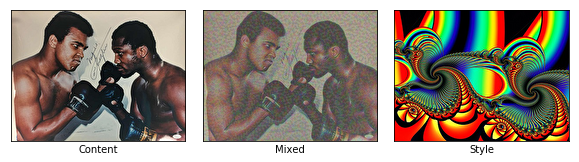

. . . . . . . . . . 
Iteration: 10


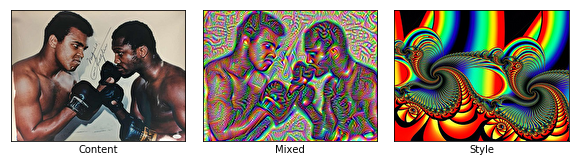

. . . . . . . . . . 
Iteration: 20


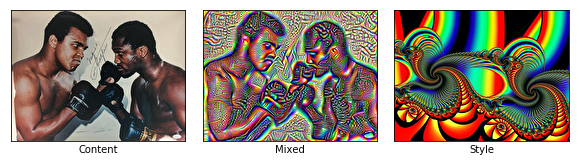

. . . . . . . . . . 
Iteration: 30


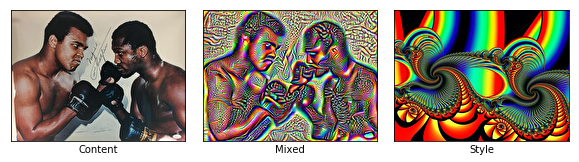

. . . . . . . . . . 
Iteration: 40


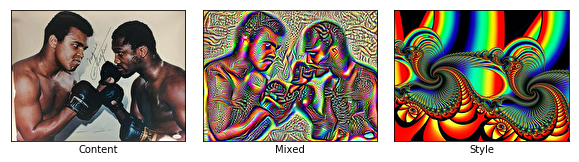

. . . . . . . . . . 
Iteration: 50


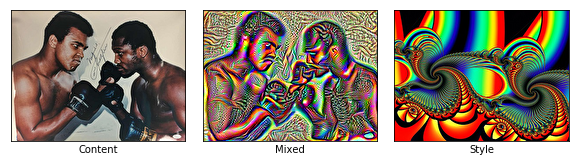

. . . . . . . . . . 
Iteration: 60


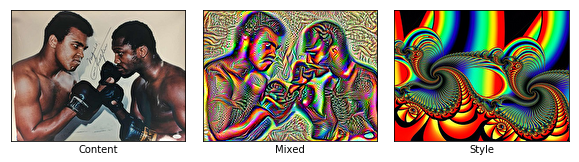

. . . . . . . . . . 
Iteration: 70


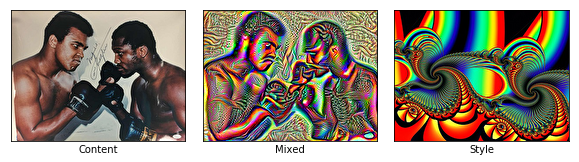

. . . . . . . . . . 
Iteration: 80


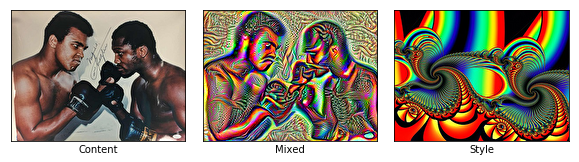

. . . . . . . . . . 
Iteration: 90


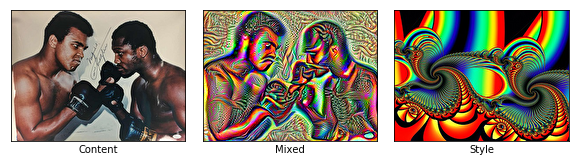

. . . . . . . . . 
Iteration: 99


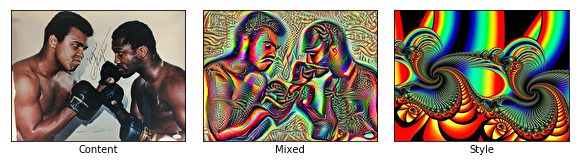


Here's our final image :


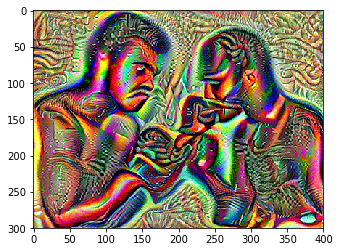

In [10]:
image = model_nn(sess, generated_image, num_iterations = 100)

image = image + CONFIG.MEANS
image = np.clip(image[0], 0, 255).astype('uint8')
# Show the generate image
print("Here's our final image :")
_ = imshow(image)

You see our generated image is a combination of content image and style image!


If you want more style involved or more content involved into the generated image, try changine the hyperparameters, alpha and beta. Also try changing the lamba in style for each layer to see some interesting results!

# End. 